In [1]:
import numpy as np
import pandas as pd
from utils.simulators import Steel_APT_Dataset
from utils.models import LUNAR_Ryan
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from pythresh.thresholds.iqr import IQR
from pythresh.thresholds.mad import MAD
from pythresh.thresholds.fwfm import FWFM
from pythresh.thresholds.yj import YJ
from pythresh.thresholds.zscore import ZSCORE
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.qmcd import QMCD
from pythresh.thresholds.fgd import FGD
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.clf import CLF
from pythresh.thresholds.filter import FILTER
from pythresh.thresholds.wind import WIND
from pythresh.thresholds.eb import EB
from pythresh.thresholds.regr import REGR
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.mcst import MCST
from pythresh.thresholds.hist import HIST
from pythresh.thresholds.moll import MOLL
from pythresh.thresholds.chau import CHAU
from pythresh.thresholds.gesd import GESD
from pythresh.thresholds.mtt import MTT
from pythresh.thresholds.karch import KARCH
from pythresh.thresholds.ocsvm import OCSVM
from pythresh.thresholds.clust import CLUST
from pythresh.thresholds.decomp import DECOMP
from pythresh.thresholds.meta import META
from pythresh.thresholds.vae import VAE
from pythresh.thresholds.cpd import CPD
from pythresh.thresholds.gamgmm import GAMGMM

INFO: Using numpy backend


In [3]:
thresholders = {
        'Inter-Quartile Region (IQR)':IQR(),
        'Median Absolute Deviation (MAD)':MAD(),
        'Full Width at Full Minimum (FWFM)':FWFM(),
        'Yeo-Johnson Transformation (YJ)': YJ(),
        'Z Score (ZSCORE)': ZSCORE(),
        'AUC Percentage (AUCP)': AUCP(),
        'Quasi-Monte Carlo Discreperancy (QMCD)': QMCD(),
        'Fixed Gradient Descent (FGD)': FGD(),
        'Distance Shift from Normal (DSN)': DSN(),
        'Trained Classifier (CLF)': CLF(),
        'Filtering Based (FILTER)': FILTER(),
        'Topological Winding Number (WIND)': WIND(),
        'Elliptical Boundary (EB)': EB(),
        'Regression Intercept (REGR)': REGR(),
        'Bootstrap Method (BOOT)': BOOT(),
        'Monte Carlo Statistical Tests (MCST)': MCST(),
        'Histogram Based Methods (HIST)': HIST(),
        'Mollifier (MOLL)': MOLL(),
        "Chauvenet's Criterion (CHAU)": CHAU(),
        'Generalized Extreme Studentized Deviate (GESD)': GESD(),
        'Modified Thompson Tau Test (MTT)': MTT(),
        'Karcher Mean (KARCH)': KARCH(),
        'One-Class SVM (OCSVM)': OCSVM(),
        'Clustering (CLUST)': CLUST(),
        'Decomposition (DECOMP)': DECOMP(),
        'Meta-model (META)': META(),
        'Variational Autoencoder (VAE)': VAE(),
        'Change Point Detection (CPD)': CPD(),
        # 'Bayesian Gamma GMM (GAMGMM)': GAMGMM(skip=True), #takes ages
}

In [5]:
cluster_dataset = Steel_APT_Dataset(
    unit_cells_per_side=50,
    cluster_relative_density=800,
    cluster_atom_counts=np.full(shape=10, fill_value=50),
) #~250 cluster points & 2500 non cluster points
cluster_data = cluster_dataset.data[cluster_dataset.data['Element']!='Fe']
clusterless_data = cluster_dataset.DBScan_baseline

model = LUNAR_Ryan()

LUNAR_labels = model.get_outputs(cluster_data, clusterless_data, n_neighbours=10)

In [6]:
model_labels = LUNAR_labels
model_labels = (LUNAR_labels - LUNAR_labels.min())/(LUNAR_labels - LUNAR_labels.min()).max()
true_labels = cluster_data['is cluster']

In [7]:
fig = make_subplots(rows=10, cols=3, subplot_titles=list(thresholders.keys()))

for i, (thresholder_name, thresholder) in enumerate(thresholders.items()):
    row, col = (i//3)+1, (i%3)+1
    start = time.perf_counter()
    labels = thresholder.eval(model_labels)
    threshold = thresholder.thresh_
    end = time.perf_counter()
    if threshold != None:
        fig.add_trace(go.Histogram(x=model_labels[true_labels==1], marker={'color':'blue'}), row, col)
        fig.add_trace(go.Histogram(x=model_labels[true_labels==0], marker={'color':'red'}), row, col)
        fig.add_vline(float(threshold), row, col)
    else:
        fig.add_trace(go.Histogram(x=model_labels[labels==1], marker={'color':'purple'}), row, col)
        fig.add_trace(go.Histogram(x=model_labels[labels==0], marker={'color':'pink'}), row, col)
    fig.layout.annotations[i]['text'] = f'{thresholder_name} - {end-start:.1E}s'

fig.update_layout(width=1500, height=2000, showlegend=False)
fig.show()
pass

In [8]:
data_path = r'Analysis/LUNAR Thresholder Test.xlsx'
results = {sheet: pd.read_excel(data_path, sheet_name=sheet, index_col=0) for sheet in pd.ExcelFile(data_path).sheet_names}

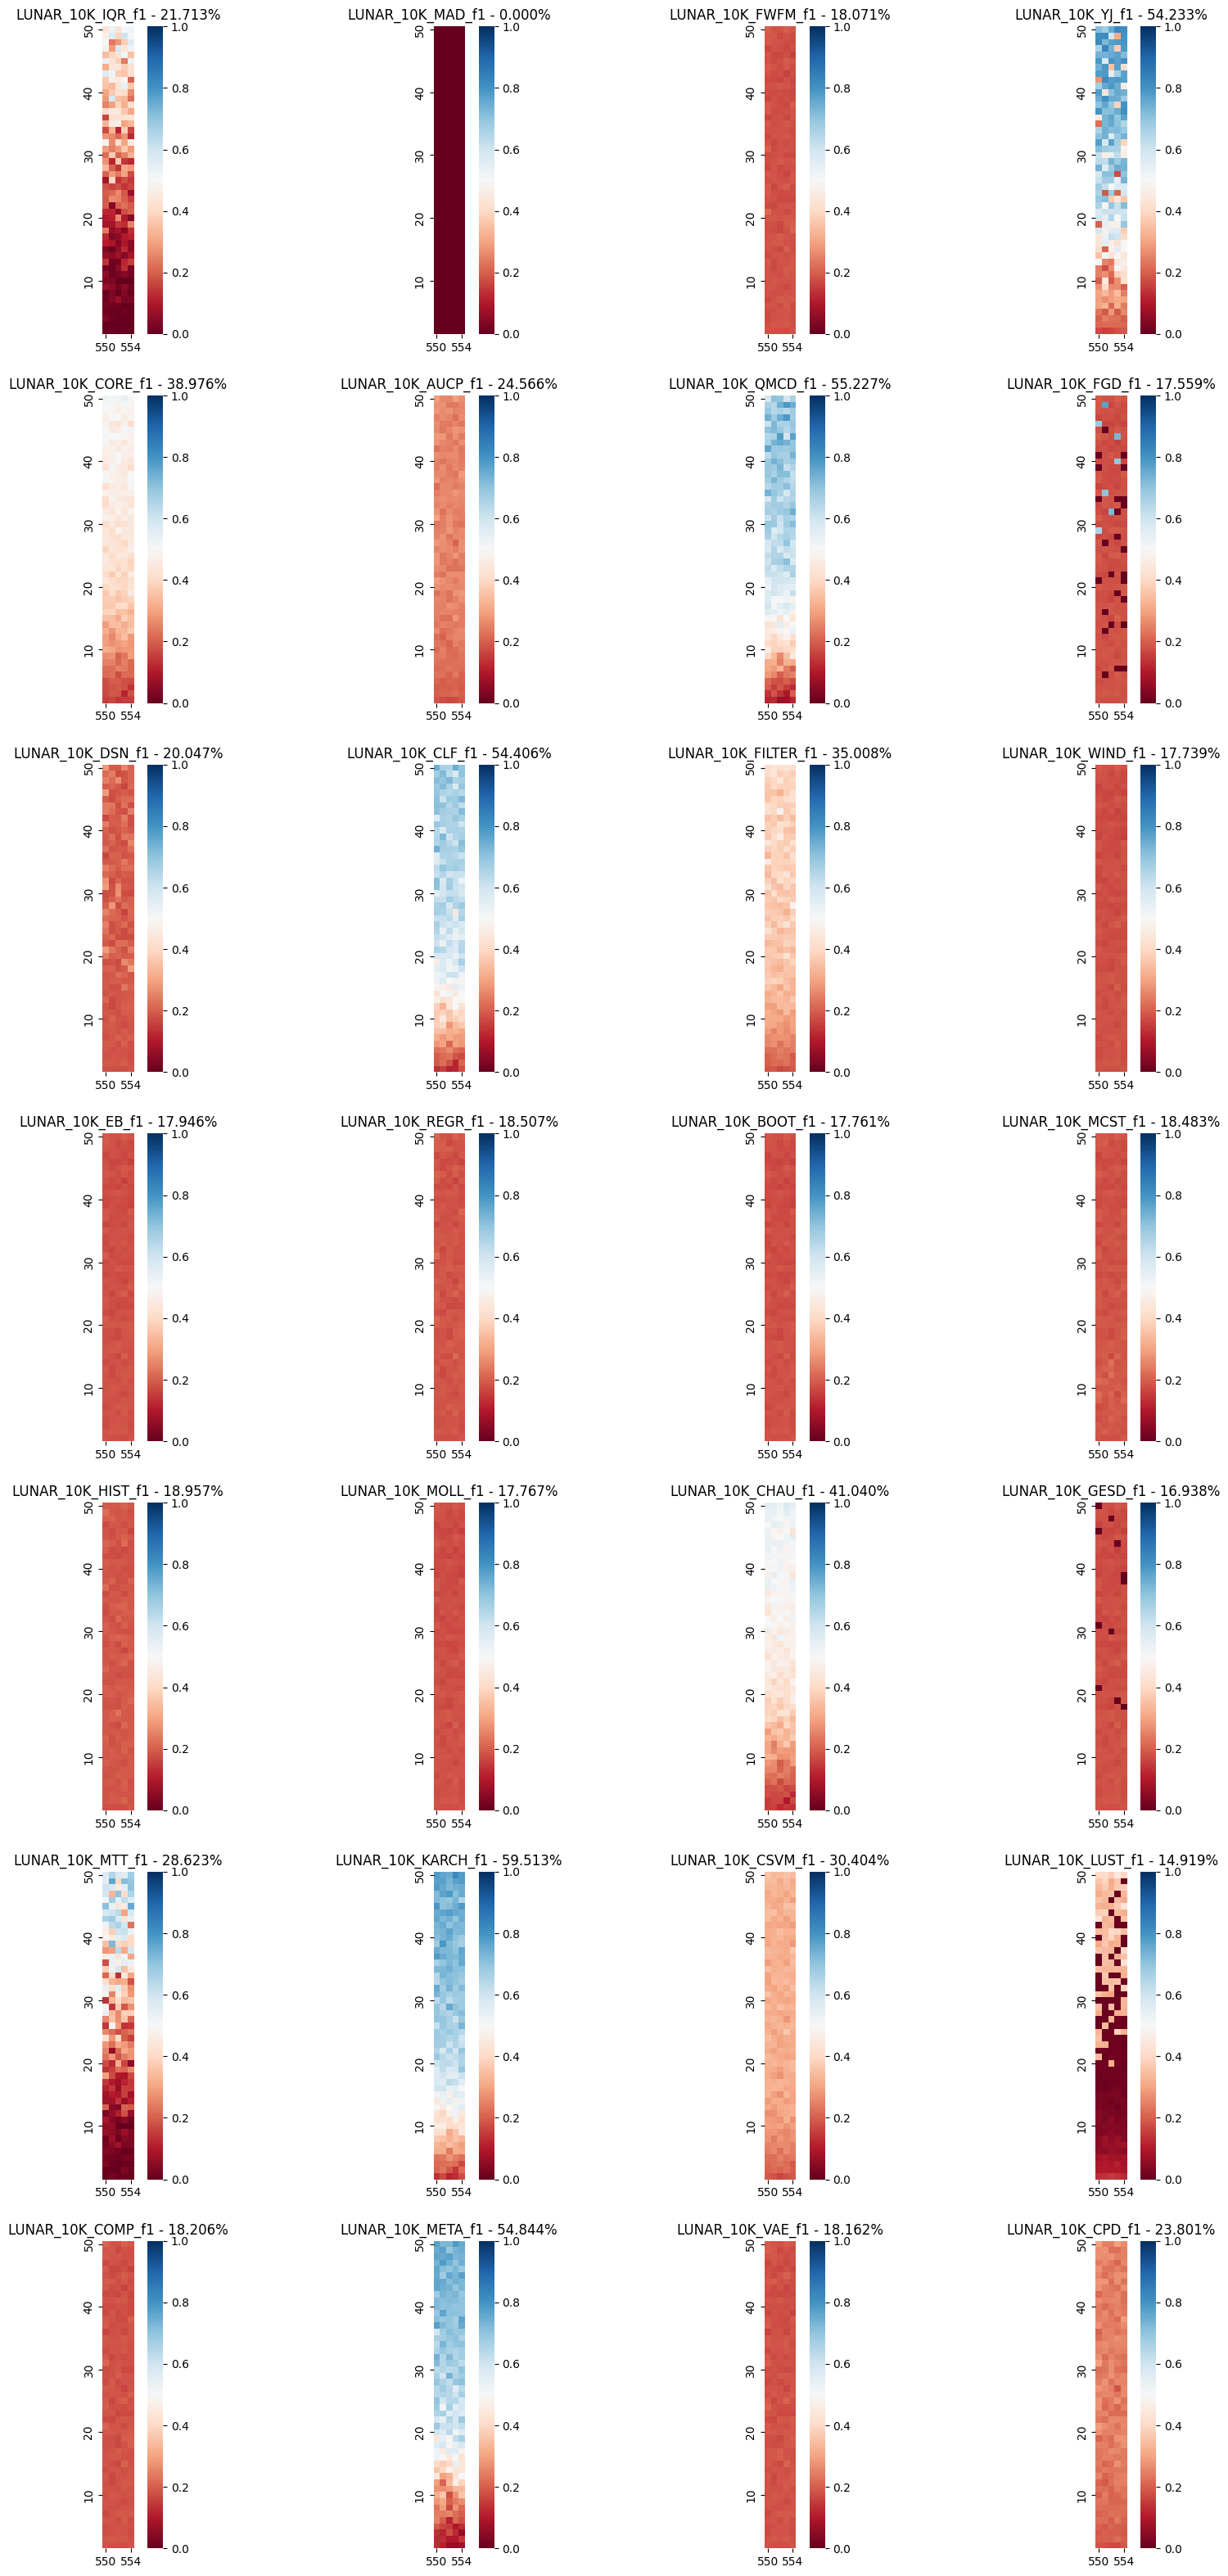

In [9]:
fig, ax = plt.subplots(nrows=7, ncols=4)
fig.set_size_inches(w=20, h=40)

for i, (name, dataframe) in enumerate(results.items()):
    axis = ax[i//4, i%4]
    mean_score = dataframe.to_numpy().mean()
    axis.set_title(f'{name} - {mean_score:.3%}')
    sns.heatmap(dataframe.loc[::-1], ax=axis, vmin=0, vmax=1,
                 square=True, xticklabels=4, yticklabels=10, cmap='RdBu')